In [4]:
# partial imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import plotly.express as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import numpy as np

# Local imports
import common_paths
import wetter_api as wt
import model_eval as me

# Model Traning

In [5]:
state = "Brandenburg"
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]

In [6]:
future_bb_weather = pd.read_csv(
    common_paths.DATA.joinpath("dwd/future_Brandenburg.csv")
)
future_bb_weather.drop(columns=["Unnamed: 0", "Bundesland"], inplace=True)
# adjust precipitation to same unit
future_bb_weather["pr"] = future_bb_weather["pr"] * 3600 * 24 * 30
future_bb_weather

pr     tasmax   sfcWind  Year  Month
0      51.580644  278.43063  4.900000  2024      1
1      54.774196  278.38547  4.761291  2024      1
2      63.967742  278.19840  4.422581  2024      1
3      47.709679  278.55966  4.416129  2024      1
4      47.709679  278.54030  4.367742  2024      1
...          ...        ...       ...   ...    ...
70390  41.612901  274.10160  4.516129  2054      1
70391  51.967742  273.57257  5.196774  2054      1
70392  51.967742  273.62740  5.316129  2054      1
70393  45.483872  273.60483  5.216129  2054      1
70394  47.419354  273.66290  5.241936  2054      1

[70395 rows x 5 columns]

In [7]:
data = me.prepare_data(parameter_list, state)
data

Year  Month station_id    pr   sfcWind  tasmax  nFires area
259   1996      1      00164   0.2  3.384206  275.15     1.0  0.0
260   1996      1      00427   0.7  3.729582  277.45     1.0  0.0
261   1996      1      00650   1.0  2.276450  277.65     1.0  0.0
262   1996      1      00880   2.8  2.746595  280.65     1.0  0.0
263   1996      1      01001   1.4  3.770945  281.15     1.0  0.0
...    ...    ...        ...   ...       ...     ...     ...  ...
8370  2022     12      03158  37.2  2.897073  290.65     0.0  0.0
8371  2022     12      03376  40.7  2.897073  290.65     0.0  0.0
8373  2022     12      03987  58.8  4.409306  290.45     0.0  0.0
8377  2022     12      05825  45.4  2.897073  289.95     0.0  0.0
8380  2022     12      07389  40.7  2.840331  290.05     0.0  0.0

[6390 rows x 8 columns]

In [8]:
test = me.station_means(data)
test_area = test.astype("float").groupby("Year")["area"].sum().reset_index()
test_nr = test.astype("float").groupby("Year")["nFires"].sum().reset_index()
sum = pd.merge(test_area, test_nr, on=["Year"], how="outer")

In [9]:
fig1 = pl.scatter(
    sum,
    x="Year",
    y="area",
    trendline="lowess",
    color_discrete_sequence=["red"],
    title="yearly burned area with trendline in Brandenburg",
    labels={"area": "burned area","Year":"year"},
)
fig2 = pl.scatter(
    sum,
    x="Year",
    y="nFires",
    trendline="lowess",
    color_discrete_sequence=["orange"],
    title="yearly number of fires with trendline in Brandenburg",
    labels={"nFires": "number of fires","Year":"year"},
)
fig1.show()
fig2.show()

Text(0, 0.5, 'number of fires')

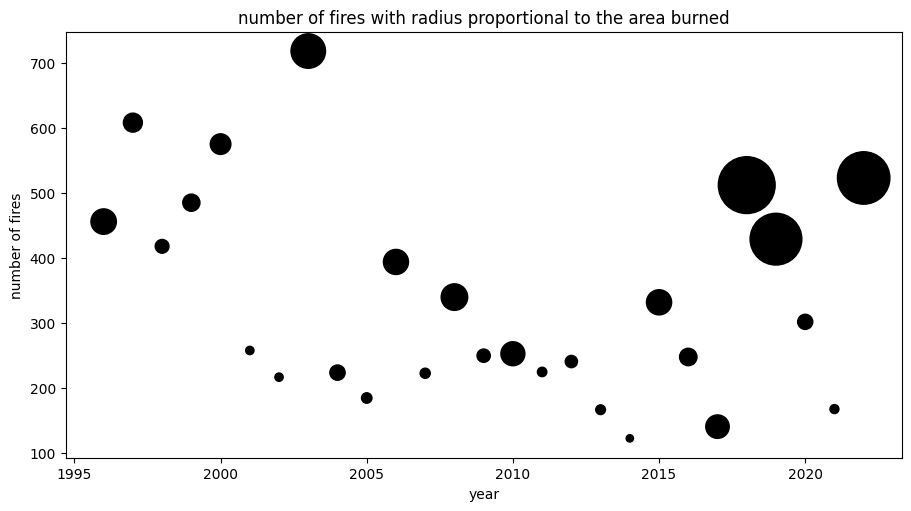

In [10]:
fig, ax = plt.subplots(figsize=(9, 5), layout="constrained")
ax.scatter("Year", "nFires", s="area", data=sum, color="black")

ax.set_title("number of fires with radius proportional to the area burned")
ax.set_xlabel("year")
ax.set_ylabel("number of fires")

In [11]:
fig1 = pl.scatter(
    data,
    x="Month",
    y="area",
    color_discrete_sequence=["red"],
    title="monthly burned area in Brandenburg",
    labels={"area": "burned area","Month":"month"},
)
fig2 = pl.scatter(
    data,
    x="Month",
    y="nFires",
    color_discrete_sequence=["orange"],
    title="monthly number of fires in Brandenburg",
    labels={"nFires": "number of fires", "Month": "month"},
)
fig1.show()
fig2.show()

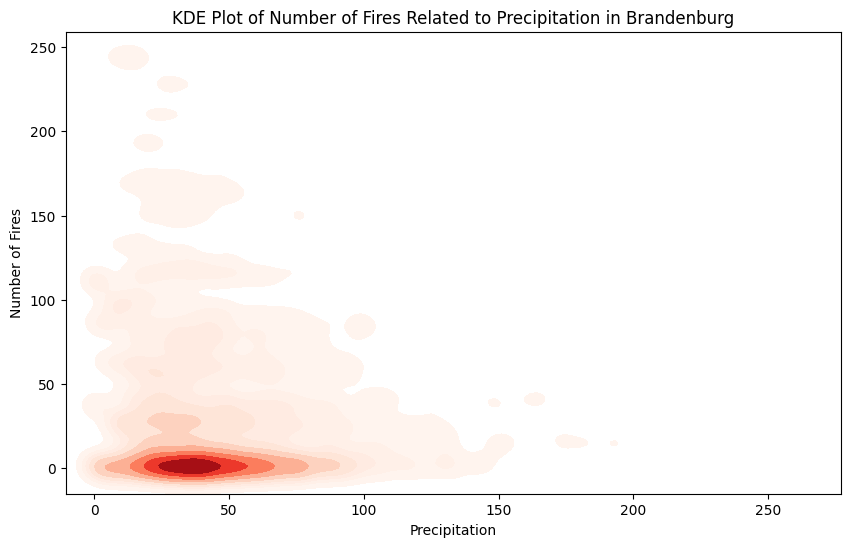

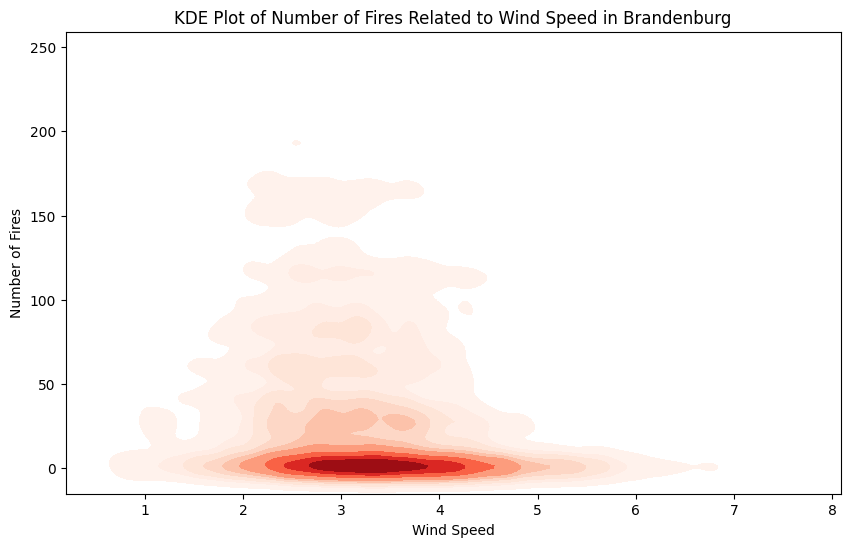

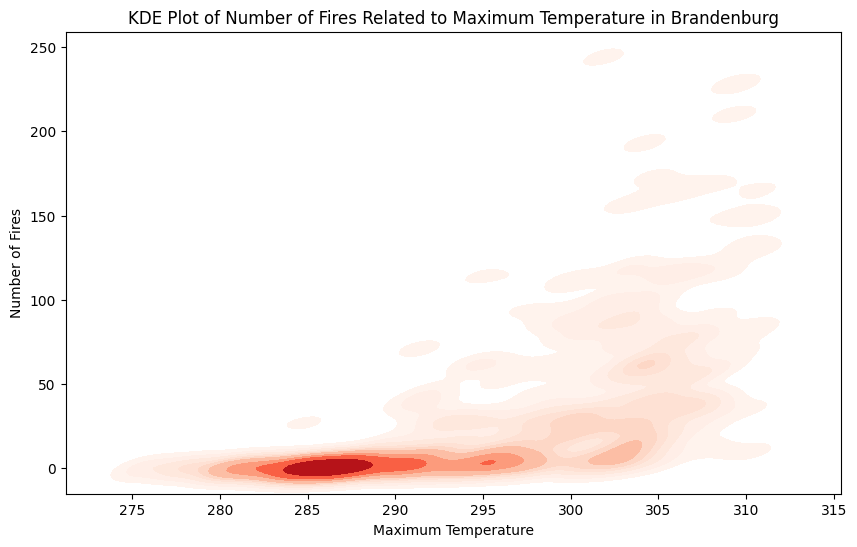

In [38]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["pr"],
    y=data["nFires"],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)
plt.title("KDE Plot of Number of Fires Related to Precipitation in Brandenburg")
plt.xlabel("Precipitation")
plt.ylabel("Number of Fires")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["sfcWind"],
    y=data["nFires"],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)
plt.title("KDE Plot of Number of Fires Related to Wind Speed in Brandenburg")
plt.xlabel("Wind Speed")
plt.ylabel("Number of Fires")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["tasmax"],
    y=data["nFires"],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)

plt.title("KDE Plot of Number of Fires Related to Maximum Temperature in Brandenburg")
plt.xlabel("Maximum Temperature")
plt.ylabel("Number of Fires")
plt.show()

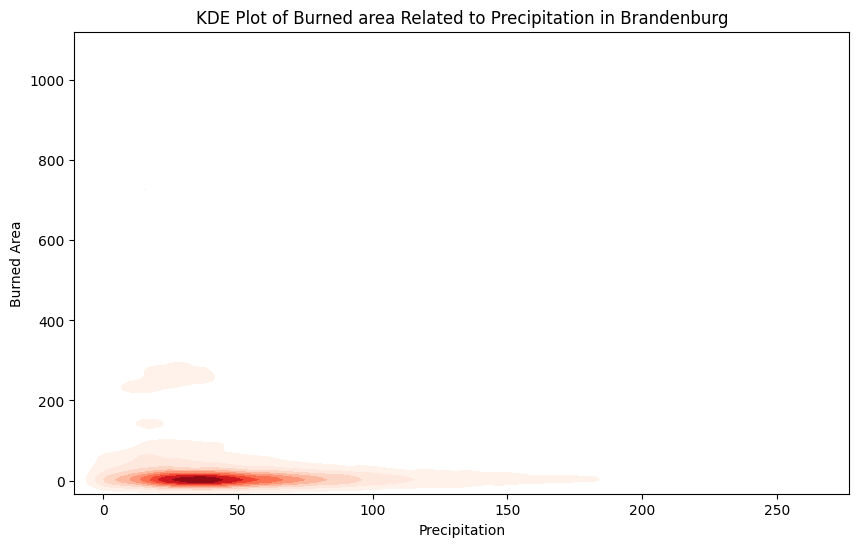

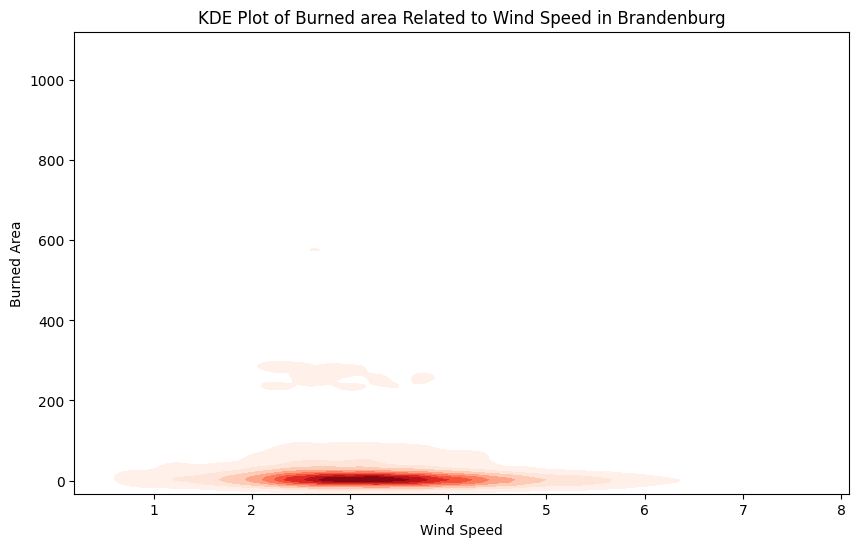

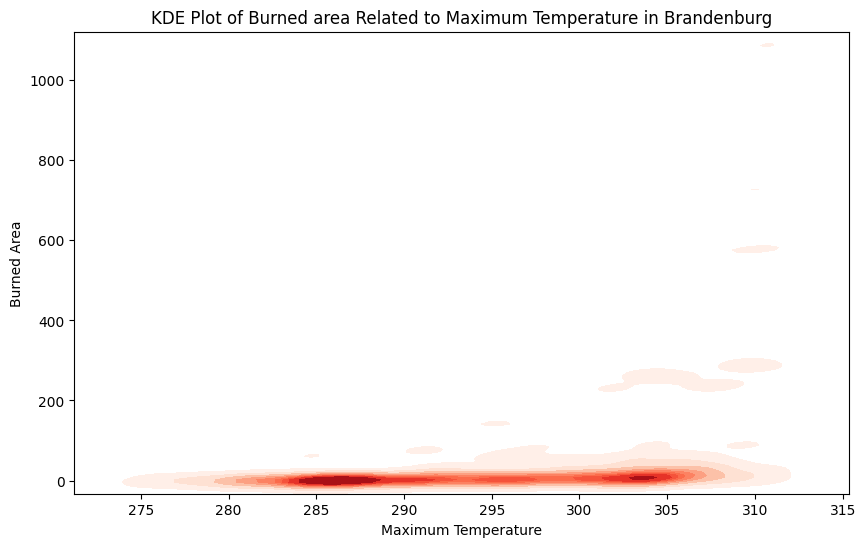

In [41]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["pr"],
    y=data["area"].astype(float),
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)
plt.title("KDE Plot of Burned area Related to Precipitation in Brandenburg")
plt.xlabel("Precipitation")
plt.ylabel("Burned Area")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["sfcWind"],
    y=data["area"].astype(float),
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)
plt.title("KDE Plot of Burned area Related to Wind Speed in Brandenburg")
plt.xlabel("Wind Speed")
plt.ylabel("Burned Area")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data["tasmax"],
    y=data["area"].astype(float),
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
)
plt.title("KDE Plot of Burned area Related to Maximum Temperature in Brandenburg")
plt.xlabel("Maximum Temperature")
plt.ylabel("Burned Area")
plt.show()

In [14]:
fig1 = pl.scatter(
    data,
    x="nFires",
    y="area",
    trendline="ols",
    color_discrete_sequence=["black"],
    title="number of fires related to burned area with trendline in Brandenburg",
    labels={"nFires": "number of fires", "area": "burned area"},
)
fig1.show()

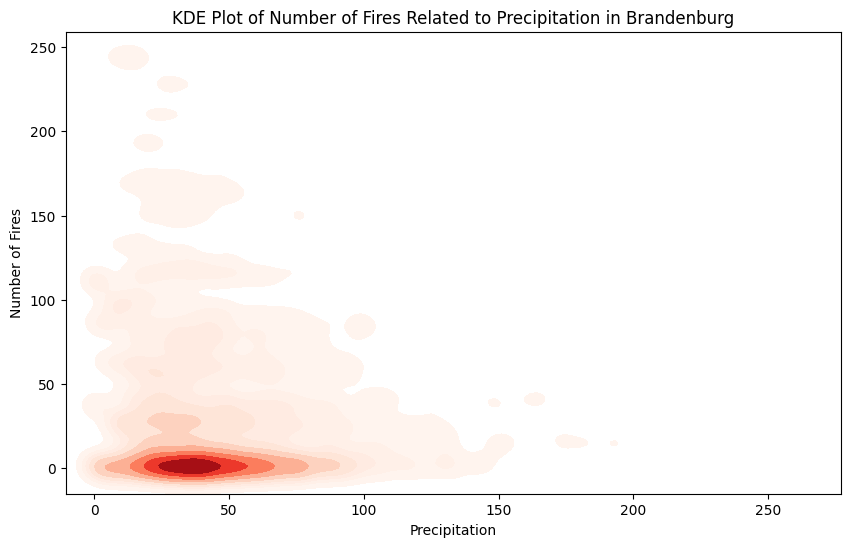

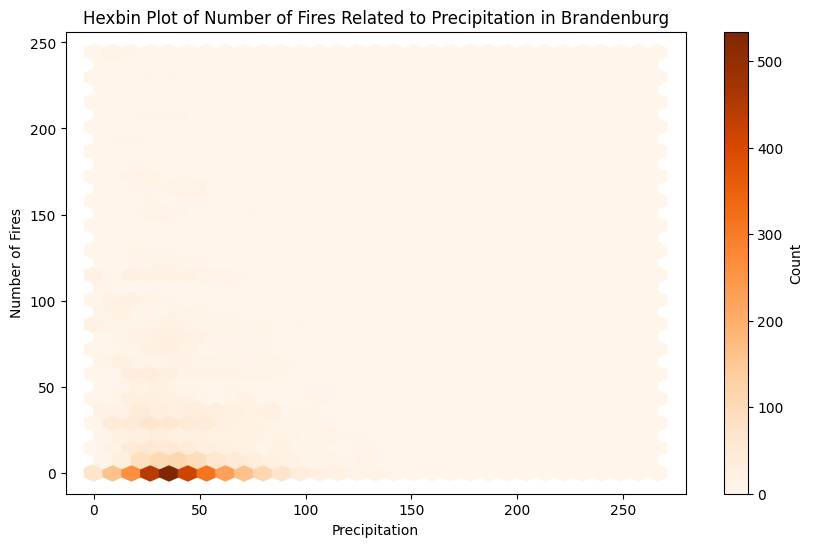

In [21]:
import pandas as pd
import matplotlib.pyplot as plt



<Axes: >

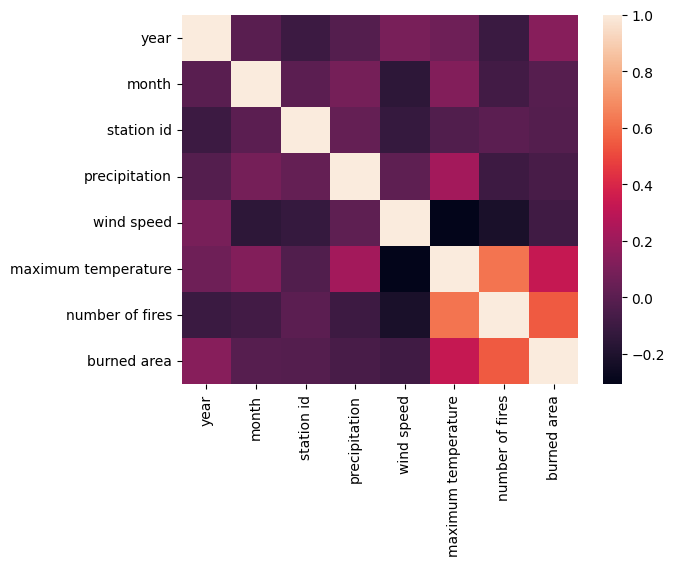

In [15]:
labels = {"nFires": "number of fires", "area": "burned area","pr":"precipitation","sfcWind":"wind speed","tasmax":"maximum temperature","Year":"year","Month":"month","station_id":"station id"}
data_renamed = data.rename(columns=labels)
sb.heatmap(data_renamed.corr(method="pearson", numeric_only=False))

In [16]:
str_parameter_list = [str(param) for param in parameter_list]
dates = data[["Year", "Month"]]
feature_list = ["sfcWind", "pr", "tasmax"]

X_nr = data[feature_list]
y_nr = data["nFires"]

# X, y, dates = shuffle(X, y, dates, random_state=42)
X_train_nr, X_test_nr, y_train_nr, y_test_nr, dates_train, dates_test = (
    train_test_split(X_nr, y_nr, dates, test_size=0.2, random_state=42)
)

In [17]:
X_scaled_train = RobustScaler().fit_transform(X_train_nr)
X_scaled_test = RobustScaler().fit_transform(X_test_nr)

In [18]:

quantile_transformer = QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_scaled_train)
X_test_trans = quantile_transformer.transform(X_scaled_test)

In [19]:

param_grid = {
    "n_estimators": [70, 80, 100],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [5, 7, 8],
}
gbr = GradientBoostingRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error"
)
# searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
nr_grid = grid_search.fit(X_scaled_train, y_train_nr)

# saving best parameters and model
nr_best_params = grid_search.best_params_
nr_best_model = grid_search.best_estimator_
print(nr_best_params)
print(nr_best_model)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80}
GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=8,
                          n_estimators=80)


In [20]:
# predict 'Anzahl Waldbrände' with the model
y_pred_nr = nr_best_model.predict(X_scaled_test)


mse = mean_squared_error(y_test_nr, y_pred_nr)
r2 = r2_score(y_test_nr, y_pred_nr)
mae = mean_absolute_error(y_test_nr, y_pred_nr)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 839.1889606565503
R2 Score: 0.5687228908606003
MAE: 16.34247633075777


# Visualisation

In [44]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
import common_paths

In [99]:
df_number = pd.read_csv(common_paths.DATA.joinpath("dwd/nr_Brandenburg.csv"))
df_area = pd.read_csv(common_paths.DATA.joinpath("dwd/area_Brandenburg.csv"))
df_predict = pd.read_csv(common_paths.DATA.joinpath("dwd/final_predictions.csv"))
df_predict["time_in_months"] = df_predict["Year"] + (df_predict["Month"] - 1) / 12

df_number["time_in_months"] = df_number["Year"] + (df_number["Month"] - 1) / 12
df_area["time_in_months"] = df_area["Year"] + (df_area["Month"] - 1) / 12
df_hist = df_number.merge(
    df_area[["Year", "Month", "area"]], on=["Year", "Month"], how="left"
)
df_hist = df_hist[df_hist["Year"] > 1995]

In [100]:
df_predict.drop(columns=["Unnamed: 0"], inplace=True)
df_predict

Year  Month      tasmax   sfcWind         pr  area_predictions  \
0    2024      1  277.818281  4.376295  51.553847          0.270256   
1    2024      2  275.542922  3.763572  13.482759          4.274414   
2    2024      3  282.054063  4.178627  21.255087          0.308581   
3    2024      4  290.934900  3.595162  20.208205         12.300988   
4    2024      5  294.976148  2.951547  47.807941          5.022404   
..    ...    ...         ...       ...        ...               ...   
356  2053      9  295.810764  2.768496  16.893846         21.231409   
357  2053     10  285.987099  3.775451  48.880397          0.270256   
358  2053     11  278.810097  3.910427  76.919488          0.270256   
359  2053     12  272.485429  3.304169  27.871464          0.270256   
360  2054      1  274.436014  4.323838  51.345410          0.270256   

     nr_predictions  time_in_months  
0          0.211310     2024.000000  
1          1.237931     2024.083333  
2          0.261001     2024.166667  
3         12.345164     2024.250000  
4          8.041631     2024.333333  
..              ...             ...  
356       47.769851     2053.666667  
357        0.274363     2053.750000  
358        0.211310     2053.833333  
359        0.211310     2053.916667  
360        0.211310     2054.000000  

[361 rows x 8 columns]

In [97]:
def compare_years(df_hist, df_predict, year_hist, year_future):
    if year_hist < 1996 or year_hist > 2022:
        print("Error: Historical dates range only from 1996 to 2022")
        return
    if year_future < 2024 or year_future > 2053:
        print("Error: Prediction dates range only from 2024 to 2053")
        return
    df_hist_year = df_hist[df_hist["Year"] == year_hist]
    df_predict_year = df_predict[df_predict["Year"] == year_future]

    fig, ax = plt.subplots(figsize=(5, 3), layout="constrained")
    ax.scatter(
        "Month",
        "nr_predictions",
        s="area_predictions",
        data=df_predict_year,
        label=year_future,
    )
    ax.scatter("Month", "nFires", s="area", data=df_hist_year, label=year_hist)
    ax.set_title("forest fires in Brandenburg")
    ax.set_xlabel("time in month")
    ax.set_ylabel("nr. of fires") 
    ax.legend()


compare_years(df_hist, df_predict, 2016, 2040)

# Known Problem

The next block of code does not perform well, we aimed to have a better perfomarce using the interaction, but the year overwrite the other and we lose the reference.

In [103]:
years_hist = range(1994, 2023)
years_predict = range(2024, 2054)
# Function to compare years
def compare_years(df_hist, df_predict):
    fig = go.Figure()

    # Add scatter plots for each year (initially hidden)
    for year in df_hist["Year"].unique():
        year_data = df_hist[df_hist["Year"] == year]
        fig.add_trace(
            go.Scatter(
                x=year_data["Month"],
                y=year_data["nFires"],
                mode="markers",
                marker=dict(size=year_data["nFires"], sizemode="area", opacity=0.6),
                name=str(year),
                visible=False,
            )
        )

    for year in df_predict["Year"].unique():
        year_data = df_predict[df_predict["Year"] == year]
        fig.add_trace(
            go.Scatter(
                x=year_data["Month"],
                y=year_data["nr_predictions"],
                mode="markers",
                marker=dict(
                    size=year_data["nr_predictions"], sizemode="area", opacity=0.6
                ),
                name=str(year),
                visible=False,
            )
        )

    # Initial layout update
    fig.update_layout(
        title="Select Years to Compare",
        xaxis_title="Month of the Year",
        yaxis_title="Number of Fires",
        showlegend=True,
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            bgcolor="rgba(255, 255, 255, 0)",
            bordercolor="rgba(255, 255, 255, 0)",
        ),
    )

    # Function to update visibility and title
    def update_visibility(year1, year2):
        visibility = [False] * len(fig.data)
        for i, trace in enumerate(fig.data):
            if trace.name == str(year1) or trace.name == str(year2):
                visibility[i] = True
        new_title = f"Number of Fires in {year1} and {year2}"
        return visibility, new_title

    # Create dropdown buttons
    year_options_hist = [
        {
            "label": str(year),
            "method": "update",
            "args": [
                dict(visible=update_visibility(year, years_predict[0])[0]),
                dict(title=f"Number of Fires in {year} and {years_predict[0]}"),
            ],
        }
        for year in df_hist["Year"].unique()
    ]
    year_options_predict = [
        {
            "label": str(year),
            "method": "update",
            "args": [
                dict(visible=update_visibility(years_hist[0], year)[0]),
                dict(title=f"Number of Fires in {years_hist[0]} and {year}"),
            ],
        }
        for year in df_predict["Year"].unique()
    ]

    # Add dropdown menus
    fig.update_layout(
        updatemenus=[
            {
                "buttons": year_options_hist,
                "direction": "down",
                "showactive": True,
                "x": 0.85,
                "xanchor": "center",
                "y": 1.15,
                "yanchor": "top",
            },
            {
                "buttons": year_options_predict,
                "direction": "down",
                "showactive": True,
                "x": 0.95,
                "xanchor": "center",
                "y": 1.15,
                "yanchor": "top",
            },
        ]
    )

    fig.show()


# Example usage
compare_years(df_hist, df_predict)

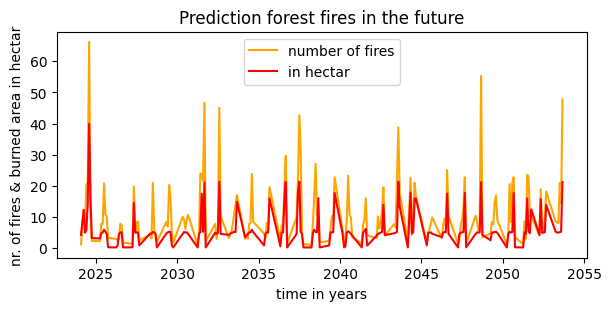

In [50]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
df_predict_nozero = df_predict_nozero[df_predict_nozero["area_predictions"] > 0.1]
fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.plot("time_in_months", "nr_predictions", data=df_predict_nozero, label="number of fires",color="orange")
ax.plot(
    "time_in_months", "area_predictions", data=df_predict_nozero, label="in hectar",color="red"
)
ax.set_title("Prediction forest fires in the future")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires & burned area in hectar")
ax.legend()
plt.show()

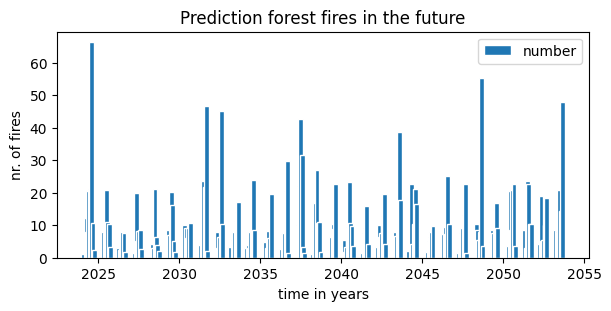

In [26]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
df_predict_nozero = df_predict_nozero[df_predict_nozero["area_predictions"] > 0.1]
fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.bar(
    "time_in_months",
    "nr_predictions",
    data=df_predict_nozero,
    label="number",
    edgecolor="white",
    width=0.3,
)
ax.set_title("Prediction forest fires in the future")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires")
ax.legend()
plt.show()

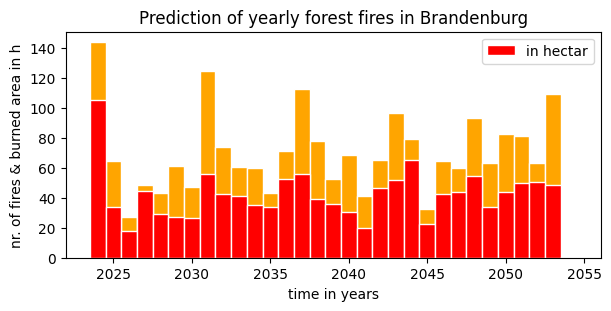

In [27]:
df_predict_avg = (
    df_predict.groupby("Year")[["nr_predictions", "area_predictions"]]
    .sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.bar(
    "Year",
    "nr_predictions",
    data=df_predict_avg,
    edgecolor="white",
    width=1,
    color="orange",
)
ax.bar(
    "Year",
    "area_predictions",
    data=df_predict_avg,
    label="in hectar",
    width=1,
    edgecolor="white",
    color="red",
)
ax.set_title("Prediction of yearly forest fires in Brandenburg")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires & burned area in h")
ax.legend()
plt.show()

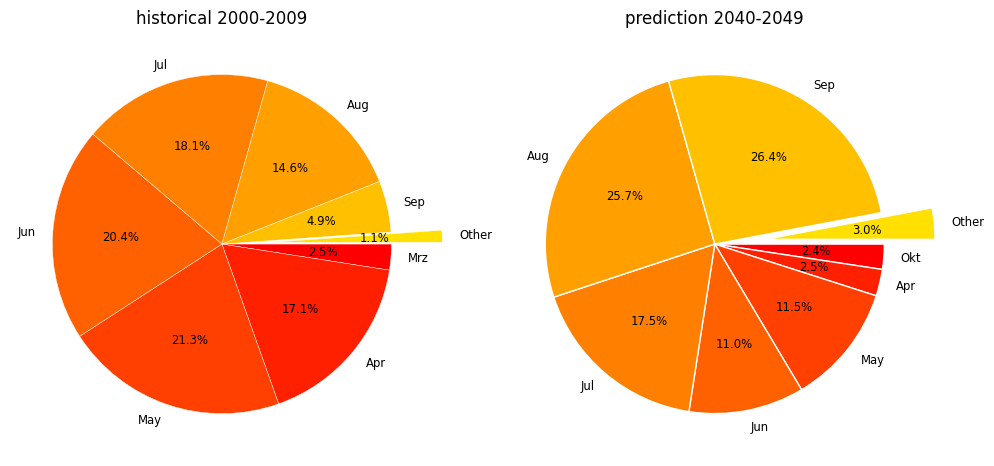

In [51]:
# data compare Months
# 2000 - 2009
df_2000 = df_hist[(df_hist["Year"] > 1999) & (df_hist["Year"] < 2010)]
df_2000 = df_2000.groupby("Month")[["nFires", "area"]].mean().reset_index()

df_2040 = df_predict[(df_predict["Year"] > 2039) & (df_predict["Year"] < 2050)]
df_2040 = (
    df_2040.groupby("Month")[["nr_predictions", "area_predictions"]]
    .mean()
    .reset_index()
)


# Combine Month with very low nr to Other
df_2040["Month"] = df_2040["Month"].apply(
    lambda x: (
        "Other"
        if df_2040.loc[df_2040["Month"] == x, "nr_predictions"].values[0] < 1.2
        else str(x)
    )
)
df_2040 = (
    df_2040.groupby("Month")[["nr_predictions", "area_predictions"]].sum().reset_index()
)


df_2000["Month"] = df_2000["Month"].apply(
    lambda x: (
        "Other"
        if df_2000.loc[df_2000["Month"] == x, "nFires"].values[0] < 2.6
        else str(x)
    )
)
df_2000 = df_2000.groupby("Month")[["nFires", "area"]].sum().reset_index()


cmap_2000 = plt.get_cmap("winter")
cmap_2040 = plt.get_cmap("autumn")

# map colors
colors_2000 = [cmap_2000(i / len(df_2000)) for i in range(len(df_2000))]
colors_2040 = [cmap_2040(i / len(df_2040)) for i in range(len(df_2040))]

# hardcoded right labels
labels_2040 = "Okt", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Other"
labels_2000 = "Mrz", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Other"

# explode Other
ax1explode = [0.3 if label == "Other" else 0 for label in df_2040["Month"]]
ax2explode = [0.3 if label == "Other" else 0 for label in df_2040["Month"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.pie(
    "nFires",
    data=df_2000,
    autopct="%1.1f%%",
    explode=ax1explode,
    textprops={"size": "smaller"},
    wedgeprops={"linewidth": 0.3, "edgecolor": "white"},
    frame=False,
    colors=colors_2040,
    labels=labels_2000,
    startangle=0,
    counterclock=False,
)
ax1.set_title("historical 2000-2009")
ax2.pie(
    "nr_predictions",
    data=df_2040,
    autopct="%1.1f%%",
    explode=ax2explode,
    textprops={"size": "smaller"},
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    frame=False,
    colors=colors_2040,
    labels=labels_2040,
    counterclock=False,
)
ax2.set_title("prediction 2040-2049")

# fig.suptitle("Monthly forest fires")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'number of fires')

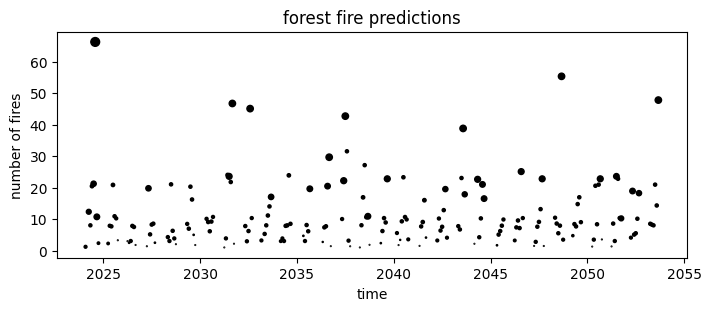

In [56]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
fig, ax = plt.subplots(figsize=(7, 3), layout="constrained")
ax.scatter(
    "time_in_months", "nr_predictions", s="area_predictions", data=df_predict_nozero,color="black"
)
ax.set_title("forest fire predictions")
ax.set_xlabel("time")
ax.set_ylabel("number of fires")

## Interaction

In [60]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]

fig = px.scatter(
    df_predict_nozero,
    x="time_in_months",
    y="nr_predictions",
    size="area_predictions",
    color="nr_predictions",
    color_continuous_scale="reds", 
    title="Forest Fire Predictions",
)

fig.update_layout(xaxis_title="time", yaxis_title="number of fires")
fig.show()

In [63]:
import dash
from dash import dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]

app = dash.Dash(__name__)

app.layout = html.Div(
    [
        dcc.Graph(id="scatter-plot"),
        dcc.RangeSlider(
            id="year-slider",
            min=df_predict_nozero["time_in_months"].min(),
            max=df_predict_nozero["time_in_months"].max(),
            value=[
                df_predict_nozero["time_in_months"].min(),
                df_predict_nozero["time_in_months"].max(),
            ],
            marks={
                str(year): str(year)
                for year in df_predict_nozero["Year"].unique()
            },
            step=1,
        ),
    ]
)


@app.callback(Output("scatter-plot", "figure"), [Input("year-slider", "value")])
def update_figure(selected_years):
    filtered_df = df_predict_nozero[
        (df_predict_nozero["time_in_months"] >= selected_years[0])
        & (df_predict_nozero["time_in_months"] <= selected_years[1])
    ]
    fig = px.scatter(
        filtered_df,
        x="time_in_months",
        y="nr_predictions",
        size="area_predictions",
        color="nr_predictions",
        color_continuous_scale="reds",
        title="Forest Fire Predictions",
    )
    fig.update_layout(xaxis_title="Time", yaxis_title="Number of Fires")
    return fig


if __name__ == "__main__":
    app.run_server(debug=True)